In [45]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

## Linear Regression Example

In [31]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [32]:
# train test split 80% - 20%
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

len(X_train), len(y_train), len(X_test), len(y_test), 

(40, 40, 10, 10)

In [33]:
# simple plotting function
def plot_pred(train_data=X_train,
              train_labels=y_train,
              test_data=X_test,
              test_labels=y_test,
              predictions=None):
    """Plot Train, Test and Predictions"""
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing Data')
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
        
    plt.legend(prop={'size': 9})

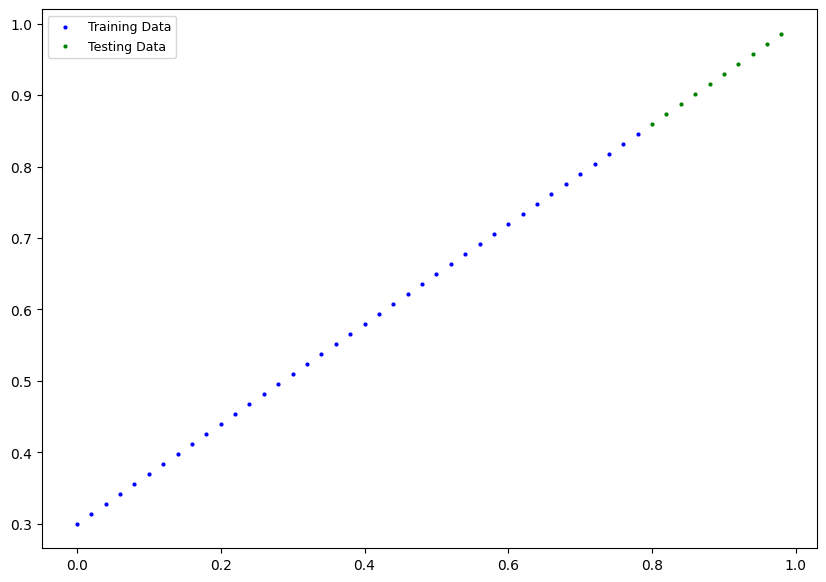

In [34]:
plot_pred()

In [35]:
# linear regression class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    
    # forward pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

#### Quick Notes
* torch.nn - contains all of the building for computational graphs (NNs)
* torch.nn.Parameter - what parameters should out model try and learn, often a PyTorch layer from torch.nn will set these automatically
* torch.nn.Module - the base class for all neural network modules, if used, there's need to overwrite def forward()

In [36]:
model_0 = LinearRegressionModel()

print(list(model_0.parameters()))
print(f'\n{list(model_0.state_dict())}')

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]

['weights', 'bias']


In [37]:
# trying torch.inference_mode()
with torch.inference_mode():
    y_preds = model_0(X_test)

# squeeze for output sizing
print(f' Predictions : {y_preds.squeeze()}')
print(f' Original (Test) : {y_test.squeeze()}')

 Predictions : tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])
 Original (Test) : tensor([0.8600, 0.8740, 0.8880, 0.9020, 0.9160, 0.9300, 0.9440, 0.9580, 0.9720,
        0.9860])


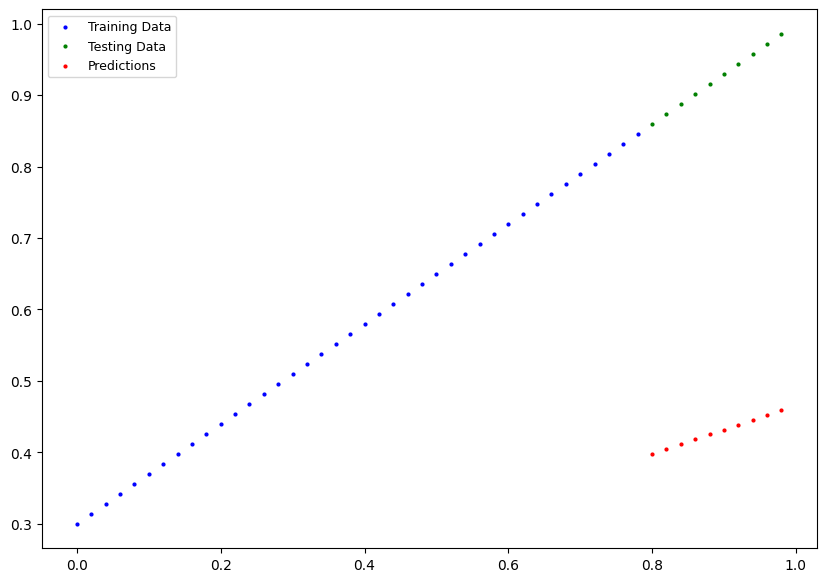

In [38]:
plot_pred(predictions=y_preds)

In [39]:
# loss function setup
loss_fn = nn.L1Loss()

# optimizer setup using stochastic gadient decent
# inputs: parameters to optimize, learning rate, how fast do we go down?
optim = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [40]:
# train loop
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

for i in range(epochs):
    # model train mode (gradient descent ON)
    model_0.train()
    
    # forward pass
    y_pred = model_0(X_train)
    
    # loss
    loss = loss_fn(y_pred, y_train)
    
    # optimizer zero grad
    optim.zero_grad()
    
    # backprop
    loss.backward()
    
    # step optimizer (gradient descent)
    optim.step()
    
    # test (turning OFF batchnorm, or dropout, etc...)
    model_0.eval()
    with torch.inference_mode():
        test_preds = model_0(X_test)
        
        test_loss = loss_fn(test_preds, y_test)
    
    if i % 10 == 0:
        print(f'Epoch: {i} | Loss: {loss}) | Test loss: {test_loss}')
    
        epoch_count.append(i)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
    

Epoch: 0 | Loss: 0.31288138031959534) | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637) | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134) | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906) | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802) | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876) | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351) | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543) | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492) | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089) | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914) | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944) | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312) | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416) | Test loss: 0.032332

In [42]:
with torch.inference_mode():
        y_preds_new = model_0(X_test)

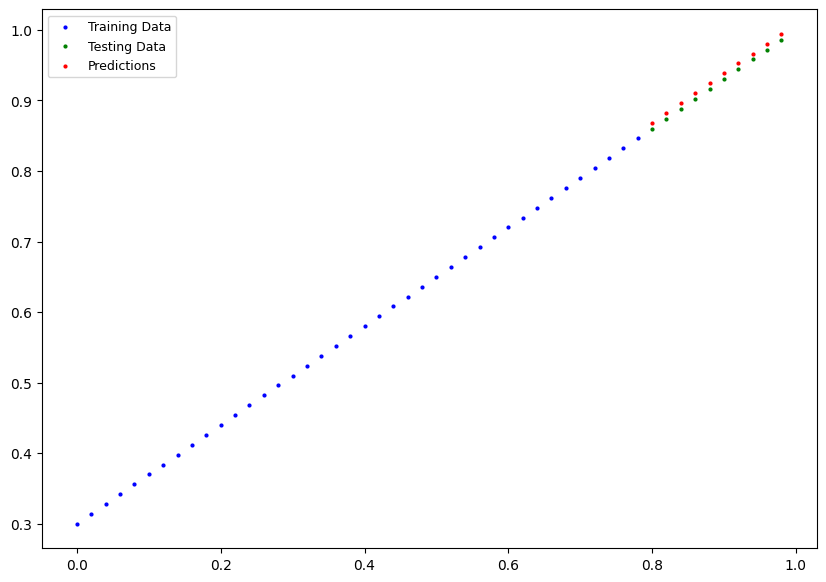

In [43]:
# working, predictions, closer to true value
plot_pred(predictions=y_preds_new)

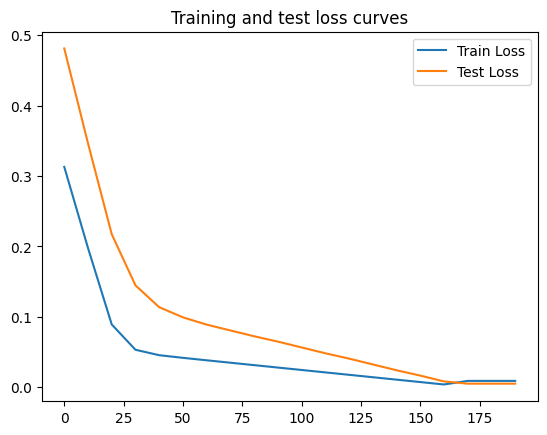

In [46]:
# plot loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.title('Training and test loss curves')
plt.legend()

### Saving/loading the model

In [47]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_NAME = '01_basic_workflow_0.pth'

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [48]:
# init
loaded_model_0 = LinearRegressionModel()

# load
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

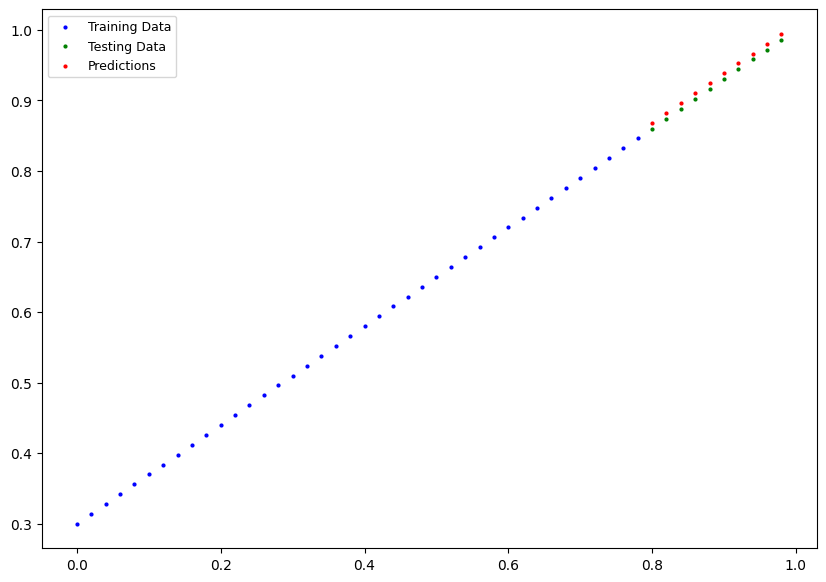

In [52]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

plot_pred(predictions=loaded_model_preds)

In [53]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Recap

In [91]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [92]:
weight = -0.7
bias = 0.87

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)

(50, 50)

In [93]:
split = int(0.8 * len(X))

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

len(X_train), len(X_test)

(40, 10)

In [94]:
# V2 of the model using nn.Linear
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

model_1 = LinearRegressionModelV2()
print(f'Model : {model_1.state_dict()}')
print(f'Model init params : {model_1.state_dict()}')

Model : OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])
Model init params : OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


In [95]:
# loss
loss_fn = nn.L1Loss()

# optimizer
optim = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [108]:
epochs = 200

for e in range(epochs):
    model_1.train()
    
    # forward
    y_pred = model_1(X_train)
    
    # loss
    loss = loss_fn(y_pred, y_train)
    
    #optim zero grad
    optim.zero_grad()
    
    # backprop
    loss.backward()
    
    #optim step SGD
    optim.step()
    
    # testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
        
    if e % 10 == 0:
        print(f'Epoch: {e} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.05636416748166084 | Test loss: 0.13105130195617676
Epoch: 10 | Loss: 0.052925340831279755 | Test loss: 0.12277892976999283
Epoch: 20 | Loss: 0.049491290003061295 | Test loss: 0.1151934266090393
Epoch: 30 | Loss: 0.04606051743030548 | Test loss: 0.10692106187343597
Epoch: 40 | Loss: 0.04262170195579529 | Test loss: 0.09864870458841324
Epoch: 50 | Loss: 0.03918931260704994 | Test loss: 0.09106320887804031
Epoch: 60 | Loss: 0.03575688228011131 | Test loss: 0.08279084414243698
Epoch: 70 | Loss: 0.03231806308031082 | Test loss: 0.07451848685741425
Epoch: 80 | Loss: 0.028887325897812843 | Test loss: 0.06693297624588013
Epoch: 90 | Loss: 0.0254532340914011 | Test loss: 0.05866061896085739
Epoch: 100 | Loss: 0.022014420479536057 | Test loss: 0.050388239324092865
Epoch: 110 | Loss: 0.018585342913866043 | Test loss: 0.04280273988842964
Epoch: 120 | Loss: 0.015149588696658611 | Test loss: 0.03453037142753601
Epoch: 130 | Loss: 0.01171182282269001 | Test loss: 0.0269448645412921

In [109]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.6977]])),
             ('linear_layer.bias', tensor([0.8615]))])

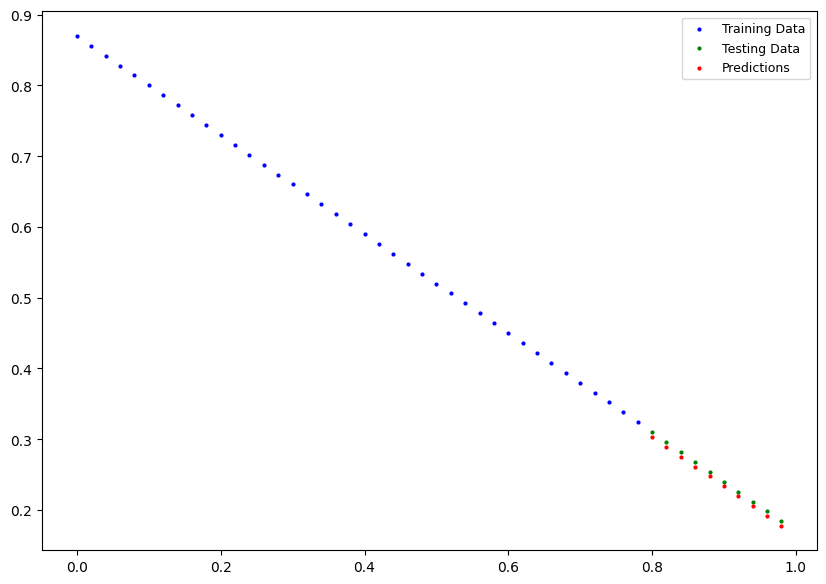

In [110]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

plot_pred(train_data=X_train,
          train_labels=y_train,
          test_data=X_test,
          test_labels=y_test,
          predictions=y_preds)

In [111]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_NAME = '01_basic_workflow_1.pth'

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)